In [7]:
from scipy import signal
from scipy.io import wavfile
from scipy.fft import fft, fftfreq, ifft
import matplotlib.pyplot as plt
import matplotlib.pyplot as plot
import matplotlib as mpl
import numpy as np

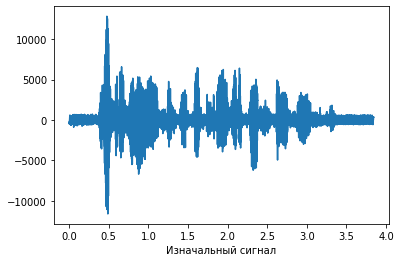

61486


In [8]:
#считали звуковой файл
sr, data = wavfile.read("Mono16kHz.wav")
freq = 16000
#смотрим на наш сигнал
time= np.arange(0,len(data))/freq

plt.plot(time,data)
plt.xlabel("Изначальный сигнал")
plt.show()

#из-за того что data рид онли - считка в буферную переменную
Signal = []
for it in data:
    Signal.append(it)
print(len(Signal))

In [15]:
#Основные параметры
Fd = 16000 #частота дискретизации
N = 2048 #Размерность ДПФ
overlap = 0.75;#смещение начала кадра для пересечения

Sr = Fd/N #текущее спектральное разрешение
#Диапазон основного тона голоса (ставим мужской)
fi = 100
fu = 300
#Переводим в отсчеты спектра (при N=2048 в одном отсчете примерно 7.8125
ni = fi / Sr
nu = fu / Sr

F0impactful = 400000;#существенное значение магнитуды (с этим проблема)
FLessimpactful = 10;#во сколько раз следующее значение форманты должно быть меньше, чтобы оно было существенно меньше

WinHamming = np.hamming(N)#генерирование окна Хэмминга для промежутка размера N

In [16]:
#Построение первой форманты F0 - траектории основного тона на записи голоса

#1 - разбиваем сигнал на отрезки длины N с перекрытиями
arrayN = [] #для хранения отрезков длины N
begin = 0#начало текущего кадра
end = N#конец текущего кадра

#пока конец кадра не выйдет за пределы. не учитывается последний участок
while end < len(data):
    it = 0
    buffN = []
    while it < N:#считываем отрезок длины N
        buffN.append(Signal[it+begin])
        it+=1
    arrayN.append(buffN)#сохраняем
    #смещаем к следующему отрезку
    begin+=int(overlap*N)
    end+=int(overlap*N)
    
print("где произошел обрыв и всего длина отрезка данных")
print(begin, len(data))
print("длина кадра, длина последнего (невошедшего участка)")
print(N, len(data)-begin)

#2 - преобразуем сигнал
it = 0
while it < len(arrayN):
    arrayN[it] = arrayN[it]*WinHamming#на каждом кадре умножаем сигнал на окно
    arrayN[it] = fft(arrayN[it])[:N//2]#вычисляем ДПФ с обрезкой
    it+=1

xf = fftfreq(int(N), 1 / freq)[:N//2]#перевод оси x-ов в частотную, также с обрезкой

#3 - поиск СУЩЕСТВЕННОГО максимального значения (выше чем F0impactful) амплитудного спектра на отрезке отсчетов [ni,nu]
#если его нет - приравниваем F = 0
print("всего сформировано кадров",len(arrayN))
begini = int(ni)
#т.к. инт обрезает в меньшую сторону
if(int(ni) < ni):
    begini+=1
F0points = []
n0array = []    
maximus = 0
maximusI = 0
it = 0

F0maximus = 0# сразу поиск максимального значения в F0 для сонограм
#прохождение по кадрам
while it < len(arrayN):
    i = begini
    #поиск в кадре частоты с значимым максимальным значением
    while i < nu:
        if maximus < np.abs(arrayN[it][i]) and np.abs(arrayN[it][i]) > F0impactful:#если существенно и больше максимума
            maximus = np.abs(arrayN[it][i]);
            maximusI = i;
        if maximus > F0maximus:
                F0maximus = maximus#для построения сонограм
        i+=1
    #Сохраняем вычисленное в кадре значение 
    F0points.append(np.abs(arrayN[it][maximusI]))#запоминаем значение амплитуды в частоте (чтобы потом можно было свериться с рисунком + для F1-F3)
    n0array.append(maximusI*Sr)#и в какой частоте оно было (n сразу домножаем)
    maximus = 0
    maximusI = 0
    it+=1


где произошел обрыв и всего длина отрезка данных
59904 61486
длина кадра, длина последнего (невошедшего участка)
2048 1582
всего сформировано кадров 39


In [17]:
#раскомментить если нужно посмотреть на частоты F0 

#найденные частоты F0
#res = []
#for it in n0array:
#    res.append(it*Sr)
#print(res)

#вывод амплитудного спектра кадра
#xf = fftfreq(int(N), 1 / freq)[:N//2]#перевод оси x-ов в частотную, также с обрезкой
#plt.plot(xf, np.abs(arrayN[15]))#np.abs() вычисляет корень суммы квадратов реальной и мнимой части
#plt.show()

#print(len(arrayN[15]))

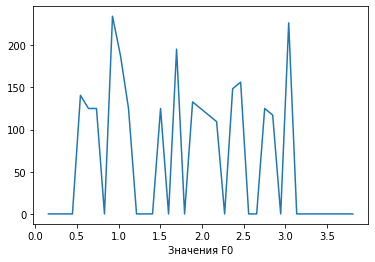

In [18]:
#отрисовка траектории F0

#подготовка шкалы времени под кадры (каждое значение времени в середине своего кадра)
time2 = []
it = 0
stepTime = N/16000
timeBuff = 0
while it < len(arrayN):
    timeBuff += 0.75*stepTime
    time2.append(timeBuff+0.5*stepTime)
    it+=1

#вывод F0
plt.plot(time2, n0array)
plt.xlabel("Значения F0")
plt.show()

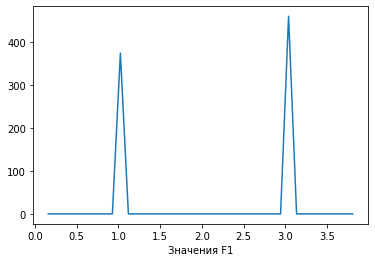

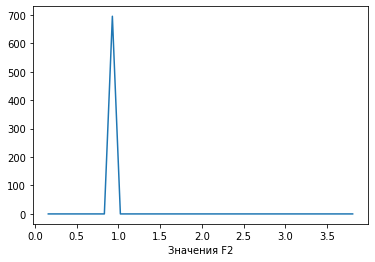

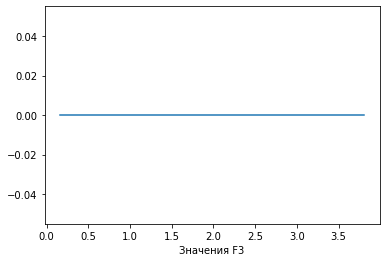

In [19]:
#Построение траектории второй, третьей и четвертой (F1, F2 и F3) форманты частот на записи голоса
#F1 ≈ 2F0, F2 ≈ 3F0, F3 ≈ 4F0.
#за существенное снижение принимаем снижение на порядок (в 10 раз) относительно предыдущего
#перемещаем найденную частоту на нужное значение и смотрим, много ли она меньше

#прохождение по кадрам для поиска F1, F2 и F3
n1array = []
n2array = []
n3array = []
it = 0
maximus = 0
maximusI = 0

#проход по всем кадрам
while it < len(arrayN):
    F0 = int(n0array[it] / Sr)#перевод назад в отсчет F0 соответствующего кадра
    
    i = 0
    F1 = 2*F0-1
    if(F1 >= 0):
        while i < 3:#как окрестности - точка в 2*F0 и две соседних
            if maximus < np.abs(arrayN[it][F1]) and np.abs(arrayN[it][F1]) < F0points[it]/FLessimpactful:#если существенно меньше значения  F0 и больше максимума
                maximus = np.abs(arrayN[it][F1]);
                maximusI = F1;
            i+=1
            F1+=1
    n1array.append(maximusI*Sr)#в какой частоте оно было (сразу домножаем отсчет)
    maximus = 0
    maximusI = 0
    
    F2 = 3*F0-1
    i = 0
    if(F2 >= 0):
        while i < 3:#как окрестности - точка в 3*F0 и две соседних
            if maximus < np.abs(arrayN[it][F2]) and np.abs(arrayN[it][F2]) < F0points[it]/(FLessimpactful**2):
                maximus = np.abs(arrayN[it][F2]);
                maximusI = F2;
            i+=1
            F2+=1
    n2array.append(maximusI*Sr)#в какой частоте оно было (сразу домножаем отсчет)
    maximus = 0
    maximusI = 0    
    
    F3 = 4*F0-1
    i = 0
    if(F3 >= 0):
        while i < 3:#как окрестности - точка в 4*F0 и две соседних
            if maximus < np.abs(arrayN[it][F3]) and np.abs(arrayN[it][F3]) < F0points[it]/(FLessimpactful**3):
                maximus = np.abs(arrayN[it][F3]);
                maximusI = F3;
            i+=1
            F3+=1
    n3array.append(maximusI*Sr)#в какой частоте оно было (сразу домножаем отсчет)
    maximus = 0
    maximusI = 0    
    
    it+=1

#выводим  траектории F1, F2 и F3 
plt.plot(time2, n1array)
plt.xlabel("Значения F1")
plt.show()

plt.plot(time2, n2array)
plt.xlabel("Значения F2")
plt.show()

plt.plot(time2, n3array)
plt.xlabel("Значения F3")
plt.show()

1635173.7429967737


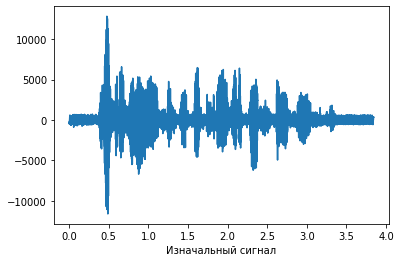

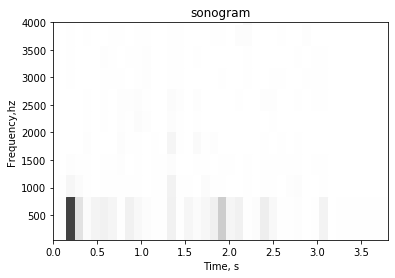

In [20]:
#Построение сонограммы голоса
#ищем Amax по всему сигналу 
Amax = F0maximus
print(Amax)

#на каждом кадре вычисляем fi/Amax на промежутке 50/4000 hz. пусть будет 10 точек (с шагом (4000-50)/10)
it = 0
frameSonoAll = []
while it < len(arrayN):
    FrameSonoOne = []
    i = int(50/Sr)
    istep = int((4000-50)/10/Sr)
    while i < 4000/Sr:
        FrameSonoOne.append(np.abs(arrayN[it][i])/Amax)
        i+=istep
    it += 1
    frameSonoAll.append(FrameSonoOne)

#разметка по оси y для сонограммы
razmetkay = []
i = int(50/Sr)
istep = int((4000-50)/10/Sr)
while i < 4000/Sr:
    i+=istep
    razmetkay.append(i*Sr)
        

#транспонируем матрицу для вывода - 
#раньше была последовательность кадров с наборами яркости в частотах, 
#будет последовательность яркостей частот разных кадров для вывода через наложение bar на plot
freqsSonoAll = [*zip(*frameSonoAll)]

#выводим сам график 
plt.plot(time,data)
plt.xlabel("Изначальный сигнал")
plt.show()

#и его сонограмму
#для этого проходимся по кадрам, выводя значение сначала самой низкой, затем накладывая поменьше и т.д.
#вывод bar-ов разного цвета сделает из них сонограмму

fig, ax = plt.subplots()
plt.title("sonogram")
plt.xlabel("Time, s")
plt.ylabel("Frequency,hz")

#выводим частоты по разметке, задавая каждому соответствующий цвет
it1 = len(razmetkay)-1
while(it1 > 0):#проходимся по всем кадрам (в 0-ле для обеления того, что не затронуто)
    barlist = ax.bar(time2, razmetkay[it1], color=list('cmy'))#задаем разметку
    it2 = 0
    while(it2 < len(time2)):
        barlist[it2].set_color(str(1-freqsSonoAll[it1][it2]))#меняем на нужные оттенки серого
        it2+=1 
    it1-=1
#вывод сонограммы
plt.ylim([50, 4000])
plt.xlim([0, time2[len(time2)-1]])
plt.show()

